<center><img src="https://raw.githubusercontent.com/mateuszk098/kaggle_notebooks/master/playground_series_s4e02/undraw_Coding_re_iv62.png" width=400px></center>

# <p style="font-family: 'JetBrains Mono'; font-weight: bold; font-size: 125%; color: #4A4B52; text-align: center">Playground Series S4E03 - Steel Plates Faults</p>

In [1]:
# %load ../utils/config.py
import glob
import logging
import operator
import os
import shutil
import subprocess
import sys
import time
import warnings
from abc import abstractmethod
from array import array
from collections import defaultdict, namedtuple
from copy import copy
from functools import partial, reduce, singledispatch
from itertools import combinations, product
from logging import Logger
from pathlib import Path
from typing import Any, Iterable, Protocol, TypeVar
from urllib.request import urlretrieve

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats
import seaborn as sns
import shap
import xgboost as xgb
import yaml
from colorama import Fore, Style
from IPython.display import HTML, Image, display_html
from matplotlib import lines
from optuna import samplers
from optuna.study import Study, StudyDirection
from optuna.trial import FrozenTrial, Trial
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Colorama settings.
CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
MAGENTA = Style.BRIGHT + Fore.MAGENTA
RESET = Style.RESET_ALL

# Ticks size for plotly and matplotlib.
TICKSIZE = 11
# Data Frame and Plotly colors.
FONT_COLOR = "#4A4B52"
GRADIENT_COLOR = "#BAB8B8"
BACKGROUND_COLOR = "#FFFCFA"
COLOR_SCHEME = np.array(("#4A4B52", "#780D0D", "#E8BA91"))

# Set Plotly theme.
pio.templates["minimalist"] = go.layout.Template(
    layout=go.Layout(
        width=820,
        height=520,
        title_font_size=20,
        font_color=FONT_COLOR,
        font_family="Open Sans",
        plot_bgcolor=BACKGROUND_COLOR,
        paper_bgcolor=BACKGROUND_COLOR,
        xaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        yaxis=dict(tickfont_size=TICKSIZE, titlefont_size=TICKSIZE, showgrid=False),
        legend=dict(x=1, y=1, yanchor="bottom", xanchor="right", orientation="h", title=""),
    ),
    layout_colorway=COLOR_SCHEME,
)
pio.templates.default = "plotly+minimalist"

# Set Matplotlib theme.
MATPLOTLIB_THEME = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": TICKSIZE,
    "axes.facecolor": BACKGROUND_COLOR,
    "axes.titlesize": 14,
    "axes.grid": False,
    "xtick.labelsize": TICKSIZE,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": TICKSIZE,
    "ytick.color": FONT_COLOR,
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.titlesize": 14,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "text.color": FONT_COLOR,
    "font.size": TICKSIZE,
    "font.family": "Serif",
}
sns.set_theme(rc=MATPLOTLIB_THEME)

# Define Data Frame theme.
CELL_HOVER = {  # for row hover use <tr> instead of <td>
    "selector": "td:hover",
    "props": f"background-color: {BACKGROUND_COLOR}",
}
TEXT_HIGHLIGHT = {
    "selector": "td",
    "props": f"color: {FONT_COLOR}; font-weight: bold",
}
INDEX_NAMES = {
    "selector": ".index_name",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
HEADERS = {
    "selector": "th:not(.index_name)",
    "props": f"font-weight: normal; background-color: {BACKGROUND_COLOR}; color: {FONT_COLOR};",
}
DF_STYLE = (INDEX_NAMES, HEADERS, TEXT_HIGHLIGHT)
DF_CMAP = sns.light_palette(GRADIENT_COLOR, as_cmap=True)

# Html style for table of contents, code highlight and url.
HTML_STYLE = """
    <style>
    code {
        background: rgba(42, 53, 125, 0.10) !important;
        border-radius: 4px !important;
    }
    a {
        color: rgba(123, 171, 237, 1.0) !important;
    }
    ol.numbered-list {
        counter-reset: item;
    }
    ol.numbered-list li {
        display: block;
    }
    ol.numbered-list li:before {
        content: counters(item, '.') '. ';
        counter-increment: item;
    }
    </style>
"""


# Utility functions.
def download_from_kaggle(expr, data_dir="data"):
    """Download all files from the Kaggle competition/dataset.

    Args:
        expr: Match expression to be used by kaggle API, e.g.
            "kaggle competitions download -c competition" or
            "kaggle datasets download -d user/dataset".
        data_dir: Optional. Directory path where to save files. Default to `data`,
        which means that files will be downloaded to `data` directory.

    Notes:
        If the associated files already exists, then it does nothing.
    """

    data_dir = Path(data_dir)

    match expr.split():
        case ["kaggle", _, "download", *args] if args:
            data_dir.mkdir(parents=True, exist_ok=True)
            filename = args[-1].split("/")[-1] + ".zip"
            if not (data_dir / filename).is_file():
                subprocess.run(expr)
                shutil.unpack_archive(filename, data_dir)
                shutil.move(filename, data_dir)
        case _:
            raise SyntaxError("expression is not compatible with Kaggle API")


def get_interpolated_colors(color1, color2, /, n_colors=1):
    """Return `n_colors` colors in HEX format, interpolated beetwen `color1` and `color2`.

    Args:
        color1: Initial HEX color to be interpolated from.
        color2: Final HEX color to be interpolated from.
        n_colors: Optional. Number of colors to be interpolated between `color1`
            and `color2`. Default to 1.

    Returns:
        colors: List of colors interpolated between `color1` and `color2`.
    """

    def interpolate(color1, color2, t):
        r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
        r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)
        r = int(r1 + (r2 - r1) * t)
        g = int(g1 + (g2 - g1) * t)
        b = int(b1 + (b2 - b1) * t)
        return f"#{r:02X}{g:02X}{b:02X}"

    return list(interpolate(color1, color2, k / (n_colors + 1)) for k in range(1, n_colors + 1))


def get_pretty_frame(
    frame,
    *,
    gradient=False,
    formatter=None,
    precision=3,
    repr_html=False,
    index_width=None,
    col_width=None,
    col_title_centering=False,
):
    frame = pd.DataFrame(frame)
    style = list(DF_STYLE)
    if index_width is not None:
        index_width_style = {
            "selector": ".index_name",
            "props": f"min-width: {index_width};",
        }
        style.append(index_width_style)
    if col_width is not None:
        col_width_style = {
            "selector": "th",
            "props": f"min-width: {col_width};",
        }
        style.append(col_width_style)
    if col_title_centering:
        col_title_style = {
            "selector": "th.col_heading",
            "props": "text-align: center;",
        }
        style.append(col_title_style)
    stylish_frame = frame.style.set_table_styles(style)  # type: ignore
    stylish_frame = stylish_frame.format(formatter=formatter, precision=precision)
    if gradient:
        stylish_frame = stylish_frame.background_gradient(DF_CMAP)
    if repr_html:
        stylish_frame = stylish_frame.set_table_attributes("style='display:inline'")
        stylish_frame = stylish_frame._repr_html_()  # type: ignore
    return stylish_frame


def numeric_descr(frame, /):
    frame = pd.DataFrame(frame)
    return (
        frame.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
        .T.drop("count", axis=1)
        .rename(columns=str.title)
    )


def frame_summary(frame, /):
    frame = pd.DataFrame(frame)
    n_null = frame.isna().sum()
    n_null_percent = n_null / len(frame) * 100.0
    n_unique = frame.apply(lambda col: len(col.dropna().unique()))
    mode_count = frame.apply(lambda col: col.value_counts().iloc[0])
    mode = frame.mode().iloc[:1].T.squeeze()
    n_unique_percent = n_unique / len(frame) * 100.0
    mode_percent_count = mode_count / len(frame) * 100.0

    return pd.DataFrame(
        {
            "dtype": frame.dtypes,
            "n_null": n_null,
            "n_null_percent": n_null_percent,
            "n_unique": n_unique,
            "n_unique_percent": n_unique_percent,
            "mode": mode,
            "mode_count": mode_count,
            "mode_percent_count": mode_percent_count,
        }
    )


def check_categories_alignment(frame1, frame2, out_color=BLUE):
    frame1 = pd.DataFrame(frame1)
    frame2 = pd.DataFrame(frame2)

    print(CLR + "The same categories in both datasets?\n")
    cat_features = frame2.select_dtypes(include=["object", "category"]).columns.to_list()

    for feature in cat_features:
        frame1_unique = set(frame1[feature].dropna().unique())
        frame2_unique = set(frame2[feature].dropna().unique())
        same = np.all(frame1_unique == frame2_unique)
        print(CLR + f"{feature:25s}", out_color + f"{same}")


def get_lower_triangular_frame(frame, /):
    frame = pd.DataFrame(frame)
    if not frame.shape[0] == frame.shape[1]:
        raise ValueError(f"{type(frame)!r} is not square frame")
    lower_triu = np.triu(np.ones_like(frame, dtype=bool))
    frame = frame.mask(lower_triu)
    return frame.dropna(axis="index", how="all").dropna(axis="columns", how="all")


def save_and_show_fig(fig, filename, img_dir="images", format="png"):
    img_dir = Path(img_dir)
    img_dir.mkdir(parents=True, exist_ok=True)
    fig_path = img_dir / (filename + "." + format)
    fig.write_image(fig_path)
    return Image(fig.to_image(format=format))


def get_n_rows_and_axes(n_features, n_cols, start_at=1):
    n_rows = int(np.ceil(n_features / n_cols))
    current_col = range(start_at, n_cols + start_at)
    current_row = range(start_at, n_rows + start_at)
    return n_rows, tuple(product(current_row, current_col))


def get_kde_estimation(
    series,
    *,
    bw_method=None,
    weights=None,
    percentile_range=(0, 100),
    estimate_points_frac=0.1,
    space_extension_frac=0.01,
    cumulative=False,
):
    """Return pdf dictionary for set of points using gaussian kernel density estimation.

    Args:
        series: The dataset with which `stats.gaussian_kde` is initialized.
        bw_method: Optional. The method used to calculate the estimator bandwidth.
        This can be 'scott', 'silverman', a scalar constant or a callable. If a scalar,
        this will be used directly as `kde.factor`. If a callable, it should take
        a `stats.gaussian_kde` instance as only parameter and return a scalar.
        If `None` (default), 'scott' is used.
        weights: Optional. Weights of datapoints. This must be the same shape as dataset.
        If `None` (default), the samples are assumed to be equally weighted.
        percentile_range: Optional. Percentile range of the `series` to create estimated space.
        By default (0, 100) range is used.
        estimate_points_frac: Optional. Fraction of `series` length to create linspace for
        estimated points.
        space_extension_frac: Optional. Estimation space will be extended by
        `space_extension_frac * len(series)` for both edges.
        cumulative: Optional. Whether to calculate cdf. Default to `False`.

    Returns:
        Dictionary with kde space, values, and cumulative values if `cumulative` is `True`.
    """

    series = pd.Series(series).dropna()
    kde = stats.gaussian_kde(series, bw_method=bw_method, weights=weights)
    start, stop = np.percentile(series, percentile_range)

    n_points = int(estimate_points_frac * len(series))
    n_extend = int(space_extension_frac * len(series))

    if n_extend > 0:
        dx = (stop - start) / (n_points - 1)
        start, stop = start - n_extend * dx, stop + n_extend * dx

    kde_space = np.linspace(start, stop, n_points)
    kde_vals = kde.evaluate(kde_space)
    results = {"space": kde_space, "vals": kde_vals}

    if cumulative:
        kde_vals_cum = np.cumsum(kde_vals)
        return results | {"vals_cumulative": kde_vals_cum / kde_vals_cum.max()}

    return results


# Html highlight. Must be included at the end of all imports!
HTML(HTML_STYLE)

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Competition Description</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The dataset for this competition (both train and test) was generated from a deep learning model trained on the <a href="https://archive.ics.uci.edu/dataset/198/steel+plates+faults"><b>Steel Plates Faults</b></a>. Feature distributions are close to, but not exactly the same, as the original.
</p>
    
<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Task</b> 
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets. To calculate the final score, AUC is calculated for each of the 7 defect categories and then averaged. In other words, the score is the average of the individual AUC of each predicted column.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Table of Contents</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The table of contents provides pleasurable navigation through the whole notebook. You can easily navigate through sections and return to TOC. If you want quickly find out something about the dataset, just read the first section, i.e. <b>Quick Overview</b>.
</p>

<blockquote class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
    background-color: #780D0D;
    border-radius: 2px;
    border: 1px solid #780D0D;
">
<ol class="numbered-list" style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    color: #F2F2F0;
    margin-top: 15px;
    margin-bottom: 15px;
">
    <li><a href="#quick_overview"><span style="color: #F2F2F0">Quick Overview</span></a>
        <ol class="numbered-list" class="numbered-list" style="
            font-size: 16px;
            font-family: 'JetBrains Mono';
        ">
            <li><a href="#data_reading_and_problem_definition"><span style="color: #F2F2F0">Data Reading &amp; Problem Definition</span></a></li>
            <li><a href="#basic_numerical_properties_summaries"><span style="color: #F2F2F0">Basic Numerical Properties &amp; Summaries</span></a></li>
            <li><a href="#playing_with_categorical_variables"><span style="color: #F2F2F0">Playing with Categorical Variables</span></a></li>
        </ol>
    </li>
</ol>
</blockquote>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Quick Overview</span></b><a class="anchor" id="quick_overview"></a> [↑](#top)

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.1</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Data Reading &amp; Problem Definition</span></b><a class="anchor" id="data_reading_and_problem_definition"></a> [↑](#top)

In [2]:
competition = "playground-series-s4e3"
competition_dataset = f"kaggle competitions download -c {competition}"

if not ON_KAGGLE:
    download_from_kaggle(competition_dataset)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="id", engine="pyarrow")
test = pd.read_csv(test_path, index_col="id", engine="pyarrow")

In [3]:
# Original dataset is not avaailable on Kaggle so we download it from UCI repository.
orig_url = "https://archive.ics.uci.edu/static/public/198/steel+plates+faults.zip"
orig_path = Path("data/steel_plates_faults.zip")
orig_path.parent.mkdir(parents=True, exist_ok=True)

if not orig_path.is_file():
    urlretrieve(orig_url, orig_path)
    shutil.unpack_archive(orig_path, "data/")

with open("data/Faults27x7_var", "r") as f:
    orig_names = f.read().splitlines()

orig = pd.read_csv("data/Faults.NNA", sep="\t", engine="pyarrow", header=None, names=orig_names)
orig = orig[train.columns]  # Sort columns to match with train dataset - also fast fail.

In [4]:
# Here I pass comma formatter since there are huge numbers in the dataset.
get_pretty_frame(orig.head(), formatter="{:,.2f}")

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42.00,50.00,"270,900.00","270,944.00",267.00,17.00,44.00,"24,220.00",76.00,108.00,"1,687.00",1.00,0.00,80.00,0.05,0.24,0.18,0.00,0.47,1.00,1.00,2.43,0.90,1.64,0.82,-0.29,0.58,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,645.00,651.00,"2,538,079.00","2,538,108.00",108.00,10.00,30.00,"11,397.00",84.00,123.00,"1,687.00",1.00,0.00,80.00,0.76,0.38,0.21,0.00,0.60,0.97,1.00,2.03,0.78,1.46,0.79,-0.18,0.30,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,829.00,835.00,"1,553,913.00","1,553,931.00",71.00,8.00,19.00,"7,972.00",99.00,125.00,"1,623.00",1.00,0.00,100.00,0.97,0.34,0.33,0.00,0.75,0.95,1.00,1.85,0.78,1.26,0.67,-0.12,0.21,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,853.00,860.00,"369,370.00","369,415.00",176.00,13.00,45.00,"18,996.00",99.00,126.00,"1,353.00",0.00,1.00,290.00,0.73,0.44,0.16,0.01,0.54,1.00,1.00,2.25,0.85,1.65,0.84,-0.16,0.52,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,"1,289.00","1,306.00","498,078.00","498,335.00","2,409.00",60.00,260.00,"246,930.00",37.00,126.00,"1,353.00",0.00,1.00,185.00,0.07,0.45,0.07,0.01,0.28,0.99,1.00,3.38,1.23,2.41,0.93,-0.20,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


In [5]:
orig.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Columns: 34 entries, X_Minimum to Other_Faults
dtypes: float64(13), int64(21)
memory usage: 515.7 KB


In [6]:
train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 19219 entries, 0 to 19218
Columns: 34 entries, X_Minimum to Other_Faults
dtypes: float64(13), int64(21)
memory usage: 5.1 MB


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Available Features</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    There are 27 available features, whereas all are numerical, so categorical analysis and encoding are probably out unless some integerized variables are categorical indeed. As for the target, we deal with seven binary features. <b>Let's look at whether it's a multi-class or multi-label competition because it's not clear here, I think.</b>
</p>

In [7]:
targets = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

orig_met = np.all(orig[targets].sum(axis=1) == 1)
train_met = np.all(train[targets].sum(axis=1) == 1)

print("Original - All Target Categories Independend:", orig_met)
print("Train - All Target Categories Independend:", train_met)

Original - All Target Categories Independend: True
Train - All Target Categories Independend: False


In [8]:
train[targets].sum(axis=1).unique()

array([1, 0, 2], dtype=int64)

In [9]:
train[targets].sum(axis=1).value_counts(normalize=True)

1    0.956345
0    0.042562
2    0.001093
Name: proportion, dtype: float64

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> It's Rather Multiclass</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    In the original dataset, all target categories are independent; there is no observation where two or more labels are present. On the other hand, in the training data, this statement is truthful in about 96% of the cases. There is a small amount of samples with two labels at the same time and 4% of samples with no category. <b>We can bring this problem to the multiclass by rejecting these 21 samples with two labels and introducing a new category like</b> <code>No_Fault</code>. In these playground competitions, training and test datasets come almost always from the same distribution, so this assumption should be valid.
</p>

In [10]:
# Bring this to the multiclass problem.
train = train[train[targets].sum(axis=1) != 2]

In [11]:
# Encode 7 + 1 categories as one target.
train_conditions = [
    train.Pastry == 1,
    train.Z_Scratch == 1,
    train.K_Scatch == 1,
    train.Stains == 1,
    train.Dirtiness == 1,
    train.Bumps == 1,
    train.Other_Faults == 1,
]
orig_conditions = [
    orig.Pastry == 1,
    orig.Z_Scratch == 1,
    orig.K_Scatch == 1,
    orig.Stains == 1,
    orig.Dirtiness == 1,
    orig.Bumps == 1,
    orig.Other_Faults == 1,
]

train["Category"] = np.select(train_conditions, targets, default="No_Fault")
orig["Category"] = np.select(orig_conditions, targets, default="No_Fault")

train = train.drop(columns=targets)
orig = orig.drop(columns=targets)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Now, the problem is a multiclass one. <b>Let's have a look at target distribution.</b>
</p>

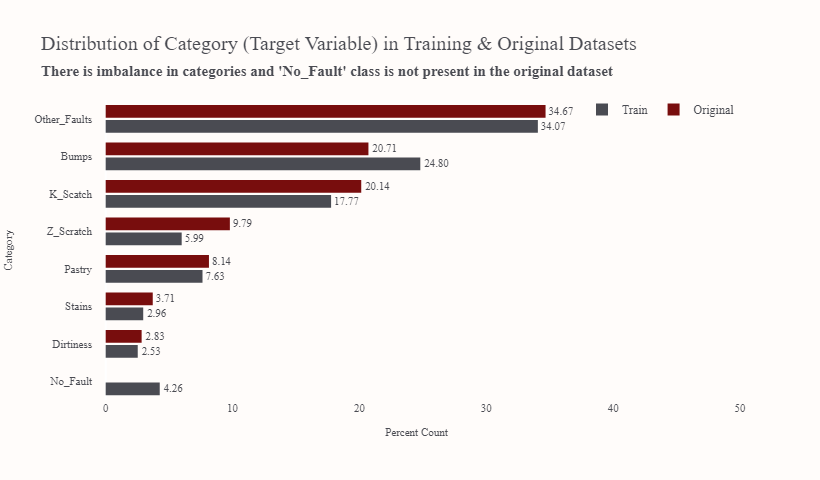

In [12]:
warnings.filterwarnings("ignore")

train_extended = pd.concat(
    (train.assign(Source="Train"), orig.assign(Source="Original")),
    ignore_index=True,
)
train_extended = train_extended.sample(frac=1.0, random_state=0)

fig = px.histogram(
    train_extended,
    y="Category",
    histnorm="percent",
    color="Source",
    color_discrete_sequence=COLOR_SCHEME,
    width=820,
    height=480,
    barmode="group",
    text_auto="0.2f",  # type: ignore
    orientation="h",
    title="Distribution of Category (Target Variable) in Training & Original Datasets<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "There is imbalance in categories and 'No_Fault' class is not "
    "present in the original dataset</span>",
)
fig.update_yaxes(title="Category", categoryorder="total ascending")
fig.update_xaxes(title="Percent Count", range=(-1, 50))
fig.update_traces(textposition="outside")
fig.update_layout(bargap=0.2, bargroupgap=0.15, legend=dict(y=0.92, x=1.0, title=""))
save_and_show_fig(fig, "status_distribution")

In [13]:
print(CLR + "Original Dataset - General Summary:")
orig_summary = frame_summary(orig)
get_pretty_frame(orig_summary, gradient=True)

Original Dataset - General Summary:


,dtype,n_null,n_null_percent,n_unique,n_unique_percent,mode,mode_count,mode_percent_count
X_Minimum,int64,0,0.000,962,49.562,41.000,126,6.491
X_Maximum,int64,0,0.000,994,51.211,212.000,23,1.185
Y_Minimum,int64,0,0.000,1939,99.897,28972.000,2,0.103
Y_Maximum,int64,0,0.000,1940,99.948,28984.000,2,0.103
Pixels_Areas,int64,0,0.000,920,47.398,52.000,19,0.979
X_Perimeter,int64,0,0.000,399,20.556,12.000,81,4.173
Y_Perimeter,int64,0,0.000,317,16.332,11.000,87,4.482
Sum_of_Luminosity,int64,0,0.000,1909,98.351,2034,2,0.103
Minimum_of_Luminosity,int64,0,0.000,161,8.295,101.000,39,2.009
Maximum_of_Luminosity,int64,0,0.000,100,5.152,127.000,194,9.995


In [14]:
print(CLR + "Training Dataset - General Summary:")
train_summary = frame_summary(train)
get_pretty_frame(train_summary, gradient=True)

Training Dataset - General Summary:


,dtype,n_null,n_null_percent,n_unique,n_unique_percent,mode,mode_count,mode_percent_count
X_Minimum,int64,0,0.000,1190,6.199,39,1593,8.298
X_Maximum,int64,0,0.000,1259,6.558,214,376,1.959
Y_Minimum,int64,0,0.000,3340,17.398,1740121,53,0.276
Y_Maximum,int64,0,0.000,3338,17.387,1740188,53,0.276
Pixels_Areas,int64,0,0.000,1152,6.001,52,260,1.354
X_Perimeter,int64,0,0.000,459,2.391,15,867,4.516
Y_Perimeter,int64,0,0.000,330,1.719,11,865,4.506
Sum_of_Luminosity,int64,0,0.000,2591,13.496,12587,54,0.281
Minimum_of_Luminosity,int64,0,0.000,162,0.844,84,540,2.813
Maximum_of_Luminosity,int64,0,0.000,98,0.510,127,2436,12.689


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Missing &amp; Unique &amp; Most Frequent Values</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>There is no missing values, so we don't need to bother about imputation and this makes the task a more pleasant.</b> There is a low diversity of values in train & test (as usual when datasets are generated artificially) and these datasets almost overlap (so I show only the training dataset). Here we also see there are 3 features that are categorical. These are: <code>TypeOfSteel_A300</code>, <code>TypeOfSteel_A400</code>, and <code>Outside_Global_Index</code>. <b>The original dataset is much more diverse.</b> See that values of <code>Y_Minimum</code>, <code>Y_Maximum</code>, and <code>Sum_of_Luminosity</code> are almost always unique for each sample, which is completely disrupted in train & test.
</p>

In [15]:
cat_features = ["TypeOfSteel_A300", "TypeOfSteel_A400", "Outside_Global_Index"]

orig[cat_features] = orig[cat_features].astype("category")
train[cat_features] = train[cat_features].astype("category")
test[cat_features] = test[cat_features].astype("category")
train_extended[cat_features] = train_extended[cat_features].astype("category")

num_features = test.select_dtypes(include="number").columns.to_list()

In [16]:
print(CLR + "Original Dataset - Numerical Summary:")
orig_num_descr = numeric_descr(orig)
get_pretty_frame(orig_num_descr, gradient=True, formatter="{:,.2f}")

Original Dataset - Numerical Summary:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
X_Minimum,571.14,520.69,0.00,0.00,14.00,51.00,435.00,"1,053.00","1,538.00","1,654.80","1,705.00"
X_Maximum,617.96,497.63,4.00,13.00,29.00,192.00,467.00,"1,072.00","1,561.00","1,675.40","1,713.00"
Y_Minimum,"1,650,684.87","1,774,578.41","6,712.00","28,533.00","86,773.00","471,253.00","1,204,128.00","2,183,073.00","4,532,922.00","10,359,325.20","12,987,661.00"
Y_Maximum,"1,650,738.71","1,774,590.09","6,724.00","28,546.40","86,815.00","471,281.00","1,204,136.00","2,183,084.00","4,532,948.00","10,359,343.20","12,987,692.00"
Pixels_Areas,"1,893.88","5,168.46",2.00,12.80,39.00,84.00,174.00,822.00,"11,211.00","18,033.40","152,655.00"
X_Perimeter,111.86,301.21,2.00,5.40,9.00,15.00,26.00,84.00,616.00,863.40,"10,449.00"
Y_Perimeter,82.97,426.48,1.00,4.00,7.00,13.00,25.00,83.00,381.00,539.00,"18,152.00"
Sum_of_Luminosity,"206,312.15","512,293.59",250.00,"1,551.00","4,347.00","9,522.00","19,202.00","83,011.00","1,293,558.00","2,155,800.80","11,591,414.00"
Minimum_of_Luminosity,84.55,32.13,0.00,19.00,29.00,63.00,90.00,106.00,124.00,170.80,203.00
Maximum_of_Luminosity,130.19,18.69,37.00,84.00,102.00,124.00,127.00,140.00,156.00,199.00,253.00


In [17]:
print(CLR + "Training Dataset - Numerical Summary:")
train_num_descr = numeric_descr(train)
get_pretty_frame(train_num_descr, gradient=True, formatter="{:,.2f}")

Training Dataset - Numerical Summary:


,Mean,Std,Min,1%,5%,25%,50%,75%,95%,99%,Max
X_Minimum,710.50,531.42,0.00,0.00,14.00,50.00,778.00,"1,152.00","1,579.00","1,673.00","1,705.00"
X_Maximum,754.34,499.83,4.00,12.00,27.00,214.00,796.00,"1,166.00","1,592.00","1,684.00","1,713.00"
Y_Minimum,"1,850,066.02","1,904,091.93","6,712.00","31,146.00","96,812.00","657,468.00","1,398,169.00","2,368,032.00","5,367,324.00","10,391,495.00","12,987,661.00"
Y_Maximum,"1,846,809.64","1,896,862.09","6,724.00","31,554.91","97,160.10","657,502.00","1,398,175.50","2,364,730.00","5,367,377.00","10,391,507.00","12,987,692.00"
Pixels_Areas,"1,674.07","3,716.47",6.00,16.00,51.00,89.00,168.00,652.00,"9,518.00","16,052.00","152,655.00"
X_Perimeter,95.12,176.99,2.00,6.00,9.00,15.00,25.00,64.00,578.00,795.00,"7,553.00"
Y_Perimeter,63.81,100.54,1.00,4.00,7.00,14.00,23.00,60.75,355.15,482.00,903.00
Sum_of_Luminosity,"190,786.23","440,685.20",250.00,"1,966.82","4,674.00","9,791.00","18,218.00","67,950.50","1,186,285.40","1,877,827.00","11,591,414.00"
Minimum_of_Luminosity,84.85,28.77,0.00,23.97,35.00,70.00,90.00,105.00,120.00,151.00,196.00
Maximum_of_Luminosity,128.64,14.20,39.00,93.00,108.00,124.00,127.00,135.00,143.00,182.00,253.00


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Numerical Summary</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    So, as we can see, the original dataset is slightly different when you ask for distributions, but the train and test subsets almost perfectly overlap (respective percentiles in both cases match) for all attributes. It is most probable that they come from the same distribution. Besides, some features contain outliers, but we will leave this problem for now. Further, I will show you how to check whether these can be removed using cross-validation.<br><br>
    Now, let's test whether we can include original data into training using an <b>adversarial validation</b>. What is the adversarial validation? <b>Well, it's a very straightforward way to check whether our subsets are similar (sampled from the same or very similar distributions).</b> We label training and original datasets with, for example, $0$ and $1$. Then, we combine them into one dataset and shuffle them. Subsequently, we can perform binary classification and assess if we're able to identify which observation is from which dataset. When we get a ROC-AUC value of around $0.5$ (random guessing), they are indistinguishable, and this case is desired. On the other hand, when ROC-AUC $>0.5$, it probably means that training and test subsets are from different distributions.
</p>

In [18]:
train_av = train.drop(columns="Category").assign(AV=0)
orig_av = orig.drop(columns="Category").assign(AV=1)

data_av = pd.concat((train_av, orig_av), ignore_index=True)
data_av = data_av.sample(frac=1.0, random_state=42)

X = data_av.drop("AV", axis=1)
y = data_av.AV

y_proba = cross_val_predict(
    estimator=make_pipeline(
        make_column_transformer(
            (
                StandardScaler(),
                make_column_selector(dtype_include="number"),  # type: ignore
            ),
        ),
        LogisticRegression(random_state=42, penalty="l2", solver="liblinear"),
    ),
    X=X,
    y=y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method="predict_proba",
)

av_scores = {
    "ConfusionMatrix": confusion_matrix(y, y_proba.argmax(axis=1)),
    "FPR-TPR-Threshold": roc_curve(y, y_proba[:, 1]),
    "ROC-AUC": roc_auc_score(y, y_proba[:, 1]),
}

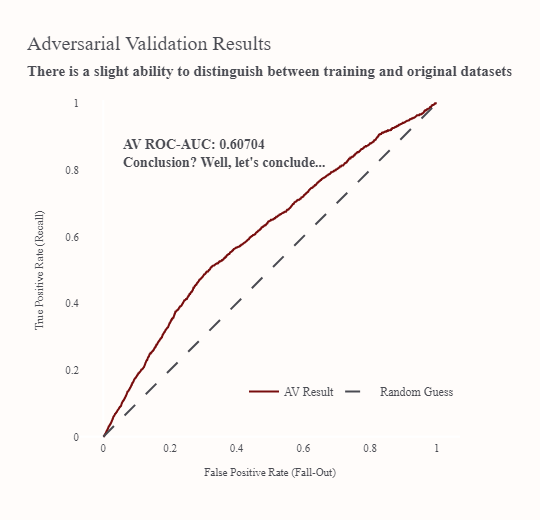

In [19]:
fig = go.Figure()
fig.add_scatter(
    x=av_scores["FPR-TPR-Threshold"][0],
    y=av_scores["FPR-TPR-Threshold"][1],
    name="AV Result",
    mode="lines",
    line_color=COLOR_SCHEME[1],
)
fig.add_scatter(
    x=[0, 1],
    y=[0, 1],
    name="Random Guess",
    mode="lines",
    line=dict(dash="longdash", color=COLOR_SCHEME[0]),
)
fig.add_annotation(
    x=0.05,
    y=0.85,
    align="left",
    xanchor="left",
    text=f"<b>AV ROC-AUC: {av_scores['ROC-AUC']:.5f}<br>" "Conclusion? Well, let's conclude...",
    showarrow=False,
    font_size=14,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="True Positive Rate (Recall)",
)
fig.update_xaxes(
    scaleanchor="y",
    scaleratio=1,
    range=(-0.01, 1.01),
    title="False Positive Rate (Fall-Out)",
)
fig.update_layout(
    title="Adversarial Validation Results<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "There is a slight ability to distinguish between training and original datasets</span>",
    width=540,
    legend=dict(y=0.1, x=1.0),
)
save_and_show_fig(fig, "adversarial_validation")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Adversarial Validation Results</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    The ROC-AUC score of $0.5$ typically indicates that the classifier cannot distinguish between the two distributions and suggests that the datasets come from the same distribution. <b>With a ROC-AUC score of $0.61$, it indicates a slight ability to distinguish between the training and original datasets, but the discrimination is not strong.</b> The score is higher than the baseline of $0.5$, suggesting some difference between the distributions, but it's not a strong signal.<b> On the other hand, the result should be as it is, as we read from competition description.</b> We're likely to include original samples in training, it usually helps in the playground. If you're asking for training and test datasets, the result is $0.5$.
</p>

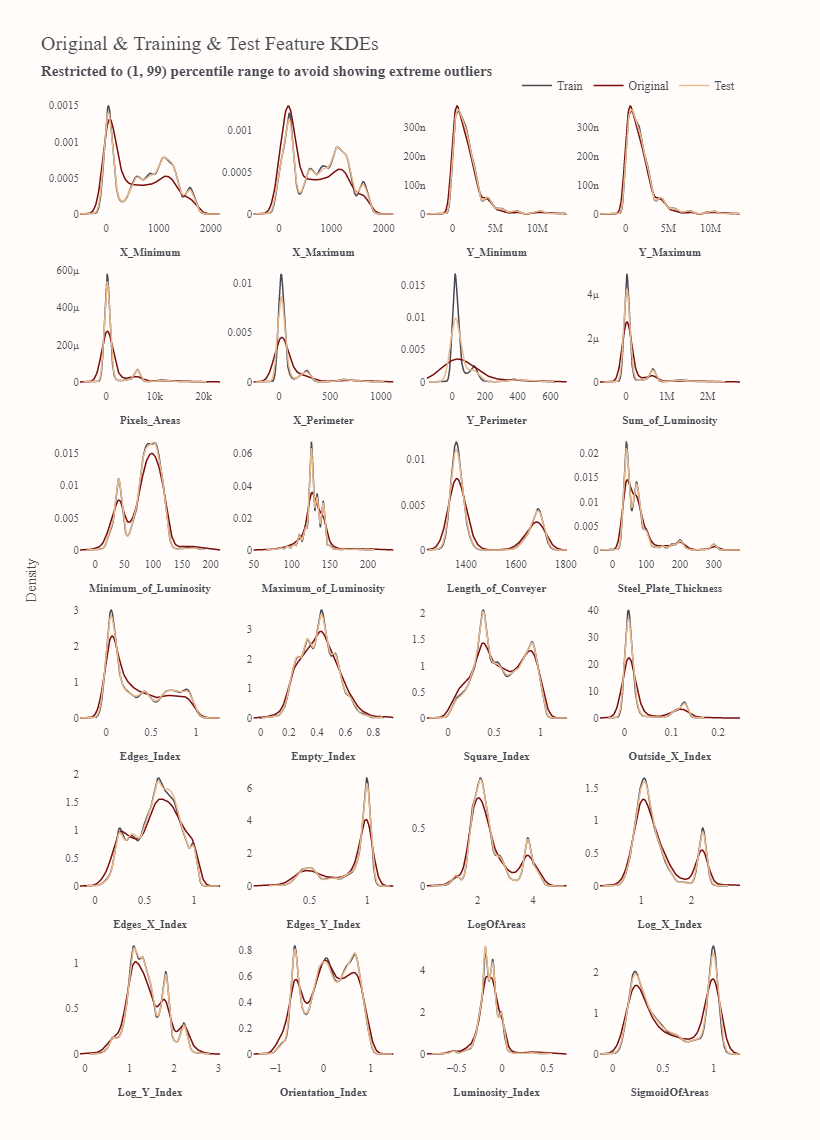

In [20]:
n_cols = 4
n_rows, axes = get_n_rows_and_axes(len(num_features), n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Density",
).update_annotations(font_size=14)

for frame, color, group in zip((train, orig, test), COLOR_SCHEME, ("Train", "Original", "Test")):
    for k, (var, (row, col)) in enumerate(zip(num_features, axes), start=1):
        kde = get_kde_estimation(frame[var], percentile_range=(1, 99), space_extension_frac=0.03)
        fig.add_scatter(
            x=kde["space"],
            y=kde["vals"],
            line=dict(dash="solid", color=color, width=1.5),
            name=group,
            legendgroup=group,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    width=820,
    height=1140,
    title="Original & Training & Test Feature KDEs<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Restricted to (1, 99) percentile range to avoid showing extreme outliers</span>",
)
save_and_show_fig(fig, "kdes")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Continuous Feature Distributions</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Feature distributions show why Logistic Regression was able to slightly distinguish between training and original data. As we can see, these distributions are indeed, slightly different, but in the end, it shouldn't be a problem. Alternatively we may cross-validate that. Let's continue analysis with cross tables concerning training dataset.
</p>

In [21]:
k_scatch_more_interesing_feats = [
    "Log_X_Index",
    "LogOfAreas",
    "X_Perimeter",
    "Pixels_Areas",
]

for feature in k_scatch_more_interesing_feats:
    cross = pd.crosstab(
        index=[pd.qcut(train[feature], q=5, duplicates="drop", precision=3)],
        columns=train.Category,
        normalize="index",
    )
    stylish_frame = get_pretty_frame(
        cross,
        gradient=True,
        formatter="{:.1%}",
        repr_html=True,
        index_width="170px",
        col_width="60px",
    )
    display_html(stylish_frame, raw=True)

Category,Bumps,Dirtiness,K_Scatch,No_Fault,Other_Faults,Pastry,Stains,Z_Scratch
Log_X_Index,,,,,,,,
"(0.3, 0.954]",24.3%,4.0%,1.8%,3.8%,37.2%,14.5%,10.6%,3.8%
"(0.954, 1.079]",34.4%,3.2%,1.9%,3.8%,38.1%,11.1%,1.0%,6.6%
"(1.079, 1.23]",31.1%,2.8%,1.9%,5.2%,41.1%,8.1%,0.5%,9.2%
"(1.23, 1.602]",31.6%,2.1%,4.4%,6.7%,42.1%,2.5%,1.1%,9.5%
"(1.602, 2.997]",3.6%,0.3%,79.1%,2.3%,12.7%,0.2%,0.0%,1.8%


Category,Bumps,Dirtiness,K_Scatch,No_Fault,Other_Faults,Pastry,Stains,Z_Scratch
LogOfAreas,,,,,,,,
"(0.777, 1.881]",31.2%,1.8%,2.2%,4.6%,35.6%,6.3%,13.9%,4.4%
"(1.881, 2.111]",35.5%,2.2%,2.0%,4.3%,41.9%,6.8%,0.5%,6.8%
"(2.111, 2.354]",30.4%,3.0%,2.1%,4.4%,40.9%,11.6%,0.2%,7.5%
"(2.354, 3.051]",24.8%,5.1%,3.3%,5.8%,40.2%,11.7%,0.0%,9.1%
"(3.051, 4.554]",2.1%,0.7%,79.4%,2.2%,11.7%,1.7%,0.0%,2.1%


Category,Bumps,Dirtiness,K_Scatch,No_Fault,Other_Faults,Pastry,Stains,Z_Scratch
X_Perimeter,,,,,,,,
"(1.999, 13.0]",31.0%,2.1%,2.5%,3.9%,35.0%,9.9%,12.6%,3.1%
"(13.0, 20.0]",34.6%,2.8%,1.5%,3.6%,39.8%,9.8%,0.9%,7.0%
"(20.0, 32.0]",30.1%,2.7%,1.5%,5.1%,42.6%,8.7%,0.8%,8.4%
"(32.0, 109.0]",25.4%,4.6%,3.8%,6.4%,41.4%,8.4%,0.2%,9.7%
"(109.0, 7553.0]",2.1%,0.4%,80.4%,2.5%,11.6%,1.2%,0.0%,1.9%


Category,Bumps,Dirtiness,K_Scatch,No_Fault,Other_Faults,Pastry,Stains,Z_Scratch
Pixels_Areas,,,,,,,,
"(5.999, 76.0]",31.2%,1.8%,2.2%,4.6%,35.6%,6.3%,13.9%,4.4%
"(76.0, 129.0]",35.5%,2.2%,2.0%,4.3%,41.9%,6.8%,0.5%,6.8%
"(129.0, 226.0]",30.4%,3.0%,2.1%,4.3%,40.9%,11.5%,0.2%,7.6%
"(226.0, 1119.4]",24.8%,5.1%,3.4%,5.8%,40.2%,11.7%,0.0%,9.1%
"(1119.4, 152655.0]",2.1%,0.7%,79.2%,2.3%,11.8%,1.8%,0.0%,2.2%


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Continuous Feature Cross Tables</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Here we create cross tables for some features versus the target variable. This gives us a handy univariate analysis of cut-off levels in particular variables and how target categories characterize this level. Each level is row-wise normalized, so for example, the $(1.602, 2.997]$ cut-off level in the <code>Log_X_Index</code> feature is characterized by 79% observations with <code>K_Scatch</code> target value. <b>I intentionally chose these features because of the</b> <code>K_Scatch</code> <b>pattern, i.e. see how much this category prevails in some cut-offs (there is more such features but no need to show these all). There is no such pattern for any features in the remaining categories, which makes</b> <code>K_Scatch</code> <b>somehow special.</b> Let's see correlations now!
</p>

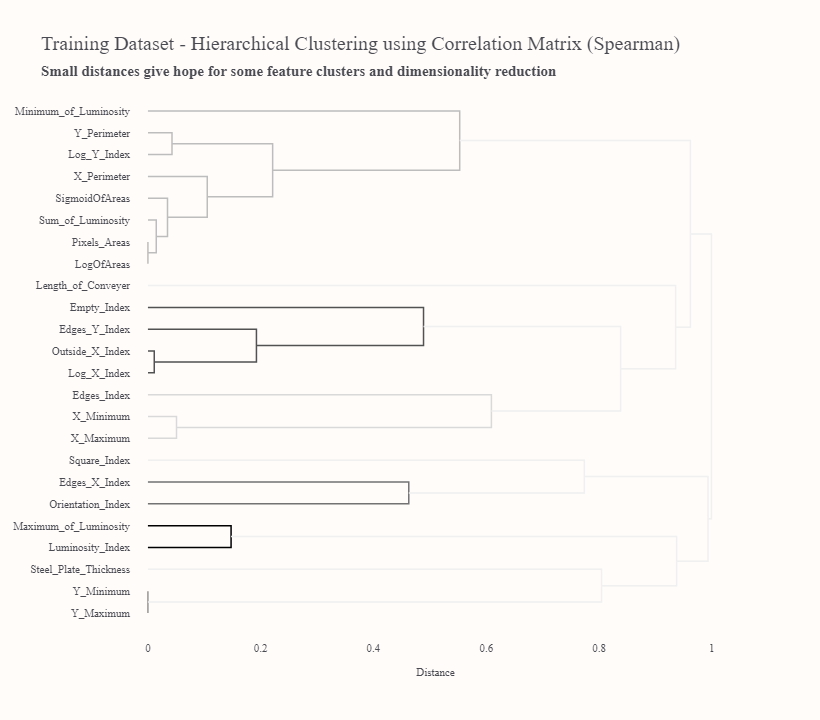

In [22]:
spearman_corr = orig.corr(method="spearman", numeric_only=True)
lower_triu_corr = get_lower_triangular_frame(spearman_corr)
dissimilarity = 1 - np.abs(spearman_corr)

fig = ff.create_dendrogram(
    dissimilarity,
    labels=spearman_corr.columns,
    orientation="left",
    colorscale=px.colors.sequential.Greys[1:],
    # squareform() returns lower triangular in compressed form - as 1D array.
    linkagefun=lambda x: linkage(squareform(dissimilarity), method="complete"),
)
fig.update_xaxes(showline=False, title="Distance", ticks="", range=[-0.03, 1.05])
fig.update_yaxes(showline=False, ticks="")
fig.update_layout(
    title="Training Dataset - Hierarchical Clustering using Correlation Matrix (Spearman)<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Small distances give hope for some feature clusters and dimensionality reduction</span>",
    height=720,
    width=820,
)
fig.update_traces(line_width=1.5, opacity=1)
save_and_show_fig(fig, "hierarchical_clustering")

In [23]:
abs_corr = (
    lower_triu_corr.abs()
    .unstack()
    .sort_values(ascending=False)  # type: ignore
    .rename("ABS Spearman Correlation")
    .to_frame()
    .reset_index(names=["Feature 1", "Feature 2"])
    .dropna()
    .round(5)
)

with pd.option_context("display.max_rows", 10):
    print(abs_corr)

                 Feature 1          Feature 2  ABS Spearman Correlation
0             Pixels_Areas         LogOfAreas                   1.00000
1                Y_Minimum          Y_Maximum                   1.00000
2          Outside_X_Index        Log_X_Index                   0.98866
3             Pixels_Areas  Sum_of_Luminosity                   0.98509
4        Sum_of_Luminosity         LogOfAreas                   0.98509
..                     ...                ...                       ...
271              X_Minimum          Y_Maximum                   0.00355
272              X_Minimum          Y_Minimum                   0.00353
273  Maximum_of_Luminosity     SigmoidOfAreas                   0.00272
274              Y_Maximum        Log_Y_Index                   0.00064
275              Y_Minimum        Log_Y_Index                   0.00058

[276 rows x 3 columns]


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Correlations &amp; Hierarchical Clustering</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    There we have Spearman correlation visual analysis. I intentionally use Spearman because, for this dataset, this type of correlation gives more higher results, so we perhaps deal with non-linear dependencies. As you notice, there are clear non-linear correlations, <b>but the question is are these pairs indeed correlated, or is it an impact of some outliers?</b> We will check this later on scatter-pair plots. As for hierarchical clustering, we just use to assess whether there are feature clusters. In this specific example, I've used <code>complete</code> method in <code>linkage</code> function, and if you use a different method, you may get different results.<br><br> 
    <b>Let's have a look at highly correlated pairs on scatter-pair plots.</b>
</p>

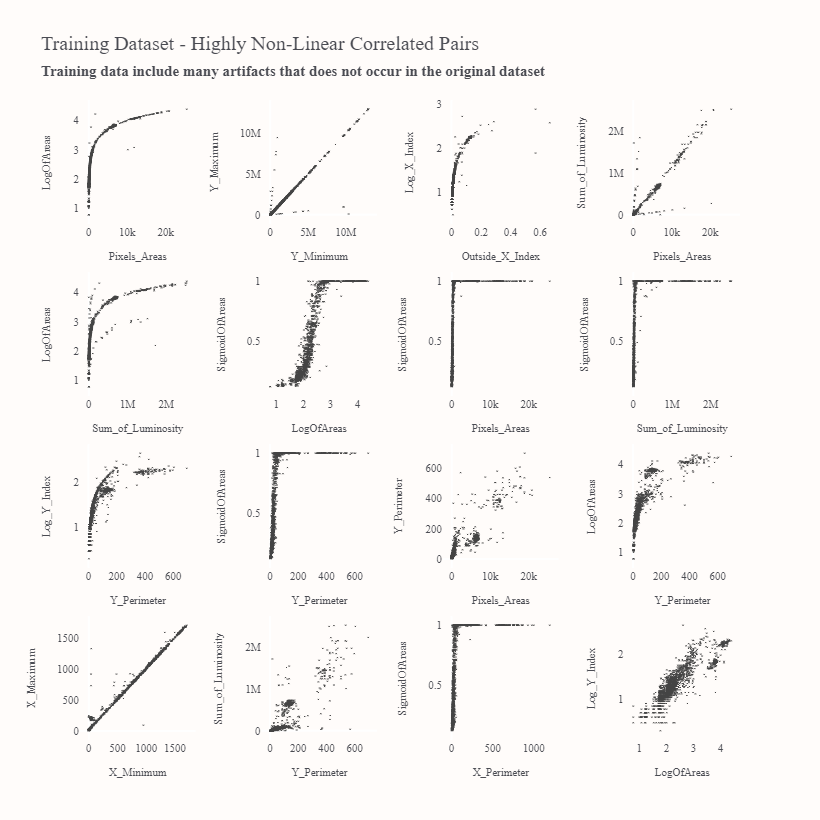

In [24]:
n_cols, n_pairs = 4, 16
n_rows, axes = get_n_rows_and_axes(n_pairs, n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    horizontal_spacing=0.1,
)

for (row, col), (feature1, feature2, corr) in zip(axes, abs_corr[:n_pairs].to_numpy()):
    fig.add_scatter(
        x=train.iloc[:2000][feature1],
        y=train.iloc[:2000][feature2],
        mode="markers",
        name="",
        row=row,
        col=col,
    )
    fig.update_xaxes(title_text=feature1, row=row, col=col)
    fig.update_yaxes(title_text=feature2, row=row, col=col)

fig.update_layout(
    title="Training Dataset - Highly Non-Linear Correlated Pairs<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "Training data include many artifacts that does not occur in the original dataset</span>",
    width=820,
    height=820,
    showlegend=False,
)
fig.update_traces(marker=dict(size=1, symbol="x-thin", line=dict(width=1)))
save_and_show_fig(fig, "train_highly_correlated_scatter_plots")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Training Scatter-Pair Plots</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Obiously in the playground series, training data includes some weird synthetic observations (see first row and second column or first row and fourth column). There are no such patterns in the original data (there are only main diagonals without samples distributed strictly horizontally and vertically).
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">1.3</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Playing with Categorical Variables</span></b><a class="anchor" id="playing_with_categorical_variables"></a> [↑](#top)

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <b>Some features are categorical. Let's visualize their dependencies with some useful stacked-bar plots.</b>
</p>

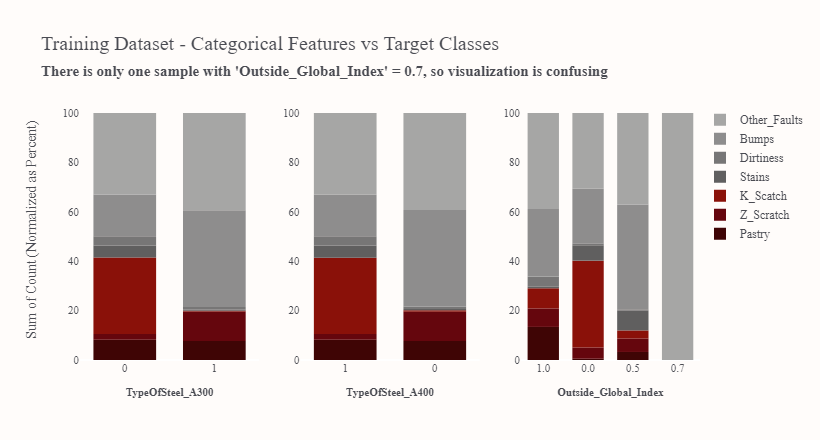

In [25]:
n_cols = 3
n_rows, axes = get_n_rows_and_axes(len(cat_features), n_cols)
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    y_title="Sum of Count (Normalized as Percent)",
)
fig.update_annotations(font_size=14)

for k, (var, (row, col)) in enumerate(zip(cat_features, axes), start=1):
    for cat, color in zip(targets, px.colors.diverging.oxy):
        fig.add_histogram(
            x=train.query(f"Category == '{cat}'")[var].astype(str),
            marker_color=color,
            name=cat,
            legendgroup=cat,
            showlegend=k == 1,
            row=row,
            col=col,
        )
        fig.update_xaxes(title_text=f"<b>{var}</b>", row=row, col=col)

fig.update_layout(
    title="Training Dataset - Categorical Features vs Target Classes<br>"
    "<span style='font-size: 75%; font-weight: bold;'>"
    "There is only one sample with 'Outside_Global_Index' = 0.7, "
    "so visualization is confusing</span>",
    width=820,
    height=440,
    barnorm="percent",
    barmode="relative",
    bargap=0.3,
    legend=dict(
        orientation="v",
        xanchor="left",
        yanchor="top",
        traceorder="reversed",
        y=0.98,
    ),
)
save_and_show_fig(fig, "categorical_bars")

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Categorical Feature Distributions</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    Bar plots above are normalized as percent count so they can be easily compared across specific categories in the target variable. Let's see:
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    text-align: justify;
    text-justify: inter-word;
">
    <li>For <code>TypeOfSteel_A300</code> and <code>TypeOfSteel_400</code> the situation is reversed in the case of <code>Bumps</code> and <code>K_Scatch</code>.</li>
    <li>For <code>Outside_Global_Index</code> feature, values of '0.7' category are dominated by 'Other_Faults' target class, but it's misleading since there is only one such observation. See below.</li>
</ul>

In [26]:
get_pretty_frame(
    pd.DataFrame(
        {
            "Train": train.Outside_Global_Index.value_counts(),
            "Test": test.Outside_Global_Index.value_counts(),
            "Original": orig.Outside_Global_Index.value_counts(),
        }
    )
)

,Train,Test,Original
Outside_Global_Index,,,
0.000000,7486,5082.000,778.000
0.500000,705,472.000,91.000
0.700000,1,nan,nan
1.000000,11006,7260.000,1072.000


In [27]:
# Let's map this.
train.Outside_Global_Index = train.Outside_Global_Index.replace({0.7: 1.0})

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Category Mismatch</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    There is no '0.7' category in test and original datasets in <code>Outside_Global_Index</code> feature. As we can see there is only one such observation in train subset in total. We can reject this category and map it to something more frequent, like '1.0'.
</p>

# <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Optuna Tuners</span></b><a class="anchor" id="optuna_tuners"></a> [↑](#top)

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.1</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Simple Preprocessing</span></b><a class="anchor" id="simple_preprocessing"></a> [↑](#top)

In [28]:
def clip_features(X, percentiles):
    X = np.asarray(X)
    lower_limit, upper_limit = np.percentile(X, percentiles, axis=0)
    return np.clip(X, lower_limit, upper_limit)


preprocess = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ["TypeOfSteel_A300", "TypeOfSteel_A400"],
    ),
    (
        OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"),
        ["Outside_Global_Index"],
    ),
    (
        make_pipeline(
            FunctionTransformer(
                clip_features,
                feature_names_out="one-to-one",
                kw_args=dict(percentiles=(0, 99)),
            ),
            StandardScaler(),
        ),
        ["Pixels_Areas", "X_Perimeter", "Sum_of_Luminosity"],
    ),
    (
        StandardScaler(),
        [
            "X_Minimum",
            "X_Maximum",
            "Y_Minimum",
            "Y_Maximum",
            "Y_Perimeter",
            "Minimum_of_Luminosity",
            "Maximum_of_Luminosity",
            "Length_of_Conveyer",
            "Steel_Plate_Thickness",
            "Edges_Index",
            "Empty_Index",
            "Square_Index",
            "Outside_X_Index",
            "Edges_X_Index",
            "Edges_Y_Index",
            "LogOfAreas",
            "Log_X_Index",
            "Log_Y_Index",
            "Orientation_Index",
            "Luminosity_Index",
            "SigmoidOfAreas",
        ],
    ),
    remainder="drop",
)

preprocess.set_output(transform="pandas")

ColumnTransformer(transformers=[('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['TypeOfSteel_A300', 'TypeOfSteel_A400']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Outside_Global_Index']),
                                ('pipeline',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(featu...
                                ('standardscaler', StandardScaler(),
                                 ['X_Minimum', 'X_Maximum', 'Y_Minimum',
                                  'Y_Maximum', 'Y_Perimeter',
                                  'Minimum_of_Luminosity',
                                  'Maximum_of_Luminosity', 'Length_of_Conveyer',
                                  'Steel_Plate_Thickness', 'Edges_Index',
                                  'Empty_Index', 'Square_Index',
                                  'Outside_X_Index', 'Edges_X_Index',
                                  'Edges_Y_Index', 'LogOfAreas', 'Log_X_Index',
                                  'Log_Y_Index', 'Orientation_Index',
                                  'Luminosity_Index', 'SigmoidOfAreas'])])

In [29]:
tmp = preprocess.fit_transform(train_extended.drop(columns="Category"))
get_pretty_frame(tmp.head())  # type: ignore

,ordinalencoder__TypeOfSteel_A300,ordinalencoder__TypeOfSteel_A400,onehotencoder__Outside_Global_Index_0.5,onehotencoder__Outside_Global_Index_0.7,onehotencoder__Outside_Global_Index_1.0,pipeline__Pixels_Areas,pipeline__X_Perimeter,pipeline__Sum_of_Luminosity,standardscaler__X_Minimum,standardscaler__X_Maximum,standardscaler__Y_Minimum,standardscaler__Y_Maximum,standardscaler__Y_Perimeter,standardscaler__Minimum_of_Luminosity,standardscaler__Maximum_of_Luminosity,standardscaler__Length_of_Conveyer,standardscaler__Steel_Plate_Thickness,standardscaler__Edges_Index,standardscaler__Empty_Index,standardscaler__Square_Index,standardscaler__Outside_X_Index,standardscaler__Edges_X_Index,standardscaler__Edges_Y_Index,standardscaler__LogOfAreas,standardscaler__Log_X_Index,standardscaler__Log_Y_Index,standardscaler__Orientation_Index,standardscaler__Luminosity_Index,standardscaler__SigmoidOfAreas
17174,1.000,0.000,0.000,0.000,1.000,-0.454,-0.457,-0.450,-1.257,-1.402,-0.209,-0.208,-0.320,0.040,-0.326,-0.710,-0.120,-0.995,-0.972,1.087,-0.489,0.075,0.764,-0.495,-0.501,-0.596,0.086,-0.659,-0.849
8711,1.000,0.000,0.000,0.000,0.000,-0.455,-0.367,-0.445,0.675,0.683,-0.795,-0.797,-0.264,0.006,2.537,1.612,0.065,0.168,-0.200,1.410,-0.425,-0.444,-1.194,-0.523,-0.178,-0.674,-0.327,2.938,-0.370
12477,0.000,1.000,0.000,0.000,1.000,-0.469,-0.482,-0.460,1.183,1.178,-0.211,-0.210,-0.302,0.900,0.288,-0.724,-0.675,-0.986,-1.114,-1.244,-0.559,-1.255,0.764,-0.786,-1.312,-0.454,1.327,0.904,-1.102
19808,0.000,1.000,0.000,0.000,0.000,1.425,1.092,1.250,-1.238,-1.051,-0.121,-0.120,0.382,-1.335,-0.189,-0.697,-0.675,-0.926,0.423,-0.720,2.040,0.103,-1.328,1.751,1.988,1.079,-1.461,-0.399,1.284
723,0.000,1.000,0.000,0.000,1.000,-0.414,-0.349,-0.423,-0.609,-0.718,0.147,0.149,-0.134,-0.235,-0.121,-0.683,1.823,0.534,0.231,-0.886,-0.483,-0.996,0.764,-0.056,-0.670,0.618,1.136,-0.722,0.536


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Dataset Ready</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    So, we brought the problem to the multiclass and checked there were no missing values and duplicated samples. Furthermore, we found out that some features are, in fact, categorical, and both training and test datasets follow the same distribution and include outliers in several features. Therefore, we write a simple preprocessing stage to rescale data, encode it, and eliminate extreme outliers by percentile clipping from one side. We also have some clusters here, but let's leave this for now. <b>Now, let's write Optua tuner and see what we can achieve with a casual approach like the one described.</b>
</p>

## <b> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">2.2</span> <span style='color: #780D0D'>|</span> <span style="font-family: 'JetBrains Mono'; color: #4A4B52">Tuner Interface</span></b><a class="anchor" id="tuner_interface"></a> [↑](#top)

In [30]:
LOG_FMT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
DATE_FMT = "%Y-%m-%d %H:%M:%S"
logging.basicConfig(level=logging.INFO, format=LOG_FMT, datefmt=DATE_FMT, force=True)

Model = TypeVar("Model")
ModelStudy = namedtuple("ModelStudy", ["hps", "study"])

In [31]:
class Tuner(Protocol):
    logger: Logger
    show_frozen: bool

    @abstractmethod
    def objective(self, trial: Trial, seed: int = 42) -> Any:
        """The `objective` function to be optimized by Optuna. Must be overridden."""

    @abstractmethod
    def define_hps(self, trial: Trial, seed: int = 42) -> dict[str, Any]:
        """Define hyperparameters for the model. Must be overridden."""

    def run_study(
        self,
        *,
        direction: str | StudyDirection,
        n_trials: int | None = None,
        timeout: float | None = None,
        seed: int = 42,
    ) -> tuple[dict[str, Any], Study]:
        sampler = samplers.TPESampler(seed=seed)
        study = optuna.create_study(direction=direction, sampler=sampler)
        study.optimize(
            func=partial(self.objective, seed=seed),
            n_trials=n_trials,
            timeout=timeout,
            callbacks=[self._logging_callback],
            n_jobs=-1,
            gc_after_trial=True,
        )
        hps = study.best_trial.user_attrs | study.best_params
        return hps, study

    def tune(
        self,
        *,
        model_name: str,
        seeds: Iterable[int],
        direction: str | StudyDirection,
        n_trials: int | None = None,
        timeout: float | None = None,
    ) -> dict[int, ModelStudy]:
        models = dict()
        models_path = Path("models/")
        models_path.mkdir(parents=True, exist_ok=True)

        for seed in seeds:
            self.logger.info(f"Fine Tuning with Seed: {seed!r}")
            best_hps, study = self.run_study(
                direction=direction, n_trials=n_trials, timeout=timeout, seed=seed
            )
            models[seed] = ModelStudy(best_hps, study)
            model_id = f"{model_name}_{seed}_{time.strftime('run_%Y_%m_%d_%H_%M_%S')}.yaml"
            with open(models_path / model_id, "w") as f:
                yaml.dump(best_hps, f)
            self.logger.info(f"Saving: {model_id!r}\n")

        return models

    def __call__(
        self,
        *,
        model_name: str,
        seeds: Iterable[int],
        direction: str | StudyDirection,
        n_trials: int | None = None,
        timeout: float | None = None,
    ) -> dict[int, ModelStudy]:
        return self.tune(
            model_name=model_name,
            seeds=seeds,
            direction=direction,
            n_trials=n_trials,
            timeout=timeout,
        )

    def _logging_callback(self, study: Study, frozen_trial: FrozenTrial) -> None:
        previous_best_value = study.user_attrs.get("previous_best_value", None)
        headline = f"Trial: {frozen_trial.number:03} - Best Value: {frozen_trial.value:.5f}"
        hps = frozen_trial.params
        if self.show_frozen:
            hps = frozen_trial.user_attrs | hps
        hps_pattern = "\n".join(f"{' ':>5}{k!r}: {v!r}," for k, v in hps.items())
        if not previous_best_value == study.best_value:
            study.set_user_attr("previous_best_value", study.best_value)
            self.logger.info(headline + "\n{\n" + hps_pattern + "\n}")

In [32]:
def lgb_roc_auc_ovr(preds, dataset):
    ground_truth = dataset.get_label()
    roc_auc = roc_auc_score(ground_truth, preds, average="macro", multi_class="ovr")
    return "roc_auc_ovr", roc_auc, True  # Higher is better - True.


def xgb_roc_auc_ovr(preds, dataset):
    ground_truth = dataset.get_label()
    roc_auc = roc_auc_score(ground_truth, preds, average="macro", multi_class="ovr")
    return "roc_auc_ovr", roc_auc

In [33]:
NUM_ITERATIONS = 1000
EARLY_STOPPING_ROUNDS = 20
MIN_DELTA = 1e-4


class LGBMTuner(Tuner):
    def __init__(
        self, X: pd.DataFrame, y: np.ndarray, preprocess: Pipeline | None = None, show_frozen=False
    ) -> None:
        self.X = X
        self.y = y
        self.preprocess = preprocess
        self.show_frozen = show_frozen
        self.logger = logging.getLogger(self.__class__.__name__)

    def objective(self, trial: Trial, seed: int = 42) -> Any:
        X, y = self.X, self.y
        hps = self.define_hps(trial, seed)
        y_proba = np.zeros((len(y), len(np.unique(y))), dtype=np.float32)
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

        for train_ids, test_ids in skfold.split(X, y):
            X_train, y_train = X.iloc[train_ids], y[train_ids]
            X_test, y_test = X.iloc[test_ids], y[test_ids]
            X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.15, stratify=y_train, random_state=seed
            )

            if self.preprocess is not None:
                X_train = self.preprocess.fit_transform(X_train)
                X_valid = self.preprocess.transform(X_valid)
                X_test = self.preprocess.transform(X_test)

            train_set = lgb.Dataset(X_train, label=y_train)
            valid_set = lgb.Dataset(X_valid, label=y_valid, reference=train_set)

            model = lgb.train(
                params=hps,
                train_set=train_set,
                valid_sets=[train_set, valid_set],
                valid_names=["train", "valid"],
                num_boost_round=NUM_ITERATIONS,
                feval=lgb_roc_auc_ovr,  # type: ignore
                callbacks=[
                    lgb.early_stopping(
                        stopping_rounds=EARLY_STOPPING_ROUNDS,
                        verbose=True,
                        min_delta=MIN_DELTA,
                        first_metric_only=True,  # No matter since we have only one metric.
                    ),
                ],
            )
            y_proba[test_ids] = model.predict(X_test)

        return roc_auc_score(y, y_proba, average="macro", multi_class="ovr")

    def define_hps(self, trial: Trial, seed: int = 42) -> dict[str, Any]:
        frozen_hps = {
            "objective": "multiclass",
            "importance_type": "gain",  # The total gain across all splits the feature is used in.
            "metric": "None",  # We will use custom metric for early stopping.
            "bagging_freq": 1,
            "num_class": 8,
            "verbose": -1,
            "seed": seed,
        }
        for k, v in frozen_hps.items():
            trial.set_user_attr(k, v)
        hps = {
            "max_depth": trial.suggest_int("max_depth", 2, 6),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 64, 512, step=32),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.5),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.1, 10, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 10, log=True),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.8, step=0.1),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.8, step=0.1),
        }
        return frozen_hps | hps

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    color: #4A4B52;
">
    <b><span style="color: #780D0D;">&#x25FC</span> Tuner's Objective</b>
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
">
    Here, I define the <code>objective()</code> method using ordinary 10-fold stratified cross-validation. Furthermore, I include original data only in the training process but not in the validation and test subsets. <b>The purpose of it is to see how the model trained on both datasets handles evaluation on a test subset which does not contain original samples (this situation corresponds to the leaderboard's assessement).</b>
</p>

In [34]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

encoder = LabelEncoder()
X = train_extended.drop(columns="Category")
y = encoder.fit_transform(train_extended.Category)

# seeds = (0,)
# timeout = 60 * 60 * 6  # 6 hours
# n_trials = 10

# lgbm_tuner = LGBMTuner(X, y, preprocess=preprocess, show_frozen=False)  # type: ignore
# models = lgbm_tuner.tune(
#     model_name="lgbm",
#     seeds=seeds,
#     direction="maximize",
#     n_trials=n_trials,
#     timeout=timeout,
# )

In [35]:
# with open("models/lgbm_0_run_2024_03_12_20_57_14.yaml", "r") as f:
#     hp = yaml.safe_load(f)

In [40]:
def draw_valid_curves(
    history, *, ax, title, xlabel, ylabel, show_legend=True, legend_loc="upper left"
):
    linestyles = iter(tuple(lines.lineStyles))
    colors = iter(COLOR_SCHEME)
    for eval_set, metrics in history.items():
        for metric, values in metrics.items():
            ax.plot(
                values,
                label=eval_set.title(),
                color=next(colors),
                linestyle=next(linestyles),
            )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if show_legend:
        ax.legend(loc=legend_loc)

    return ax

In [37]:
def train_lgb_xgb(
    *,
    X_train,
    y_train,
    X_valid,
    y_valid,
    lgb_params,
    xgb_params,
    lgb_feval,
    xgb_feval,
    num_iterations,
    early_stopping_rounds,
    min_delta,
):
    lgb_history = dict()
    lgb_train_set = lgb.Dataset(X_train, label=y_train)
    lgb_valid_set = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train_set)
    lgb_model = lgb.train(
        params=lgb_params,
        train_set=lgb_train_set,
        num_boost_round=num_iterations,
        valid_sets=[lgb_train_set, lgb_valid_set],
        valid_names=["train", "valid"],
        feval=lgb_feval,  # type: ignore
        callbacks=[
            lgb.record_evaluation(lgb_history),
            lgb.early_stopping(
                stopping_rounds=early_stopping_rounds,
                min_delta=min_delta,
                first_metric_only=True,  # No matter since we have only one metric.
                verbose=False,
            ),
        ],
    )

    xgb_history = dict()
    xgb_train_set = xgb.DMatrix(X_train, label=y_train)
    xgb_valid_set = xgb.DMatrix(X_valid, label=y_valid)
    xgb_model = xgb.train(
        params=xgb_params,
        dtrain=xgb_train_set,
        num_boost_round=num_iterations,
        evals=[(xgb_train_set, "train"), (xgb_valid_set, "valid")],
        evals_result=xgb_history,
        custom_metric=xgb_feval,
        verbose_eval=False,
        callbacks=[
            xgb.callback.EarlyStopping(  # type: ignore
                rounds=early_stopping_rounds,
                min_delta=min_delta,
                data_name="valid",
                maximize=True,
            )
        ],
    )

    return lgb_model, lgb_history, xgb_model, xgb_history

In [38]:
lgb_params = {
    "objective": "multiclass",
    "importance_type": "gain",  # The total gain across all splits the feature is used in.
    "metric": "None",  # We will use custom metric for early stopping.
    "num_class": 8,
    "verbose": -1,
    "random_state": 42,
    "max_depth": 6,
    "learning_rate": 0.055,
    "min_child_samples": 32,
    "colsample_bytree": 0.1,
    "reg_alpha": 1.586,
    "reg_lambda": 0.661,
    "subsample": 0.8,
    "subsample_freq": 1,
}

xgb_params = {
    "objective": "multi:softprob",
    "importance_type": "total_gain",  # The total gain across all splits the feature is used in.
    "disable_default_eval_metric": True,  # We will use custom metric for early stopping.
    "num_class": 8,
    "verbosity": 0,
    "random_state": 42,
    "max_depth": 5,
    "learning_rate": 0.11526,
    "colsample_bylevel": 0.8,
    "colsample_bytree": 0.5,
    "min_child_weight": 0.9,
    "reg_alpha": 1.058,
    "reg_lambda": 0.618,
    "subsample": 0.8,
}

2024-03-14 22:15:53 - CV - INFO - Results
LightGBM - Best Iter: 78 - Valid ROC-AUC: 0.85799
XGBoost  - Best Iter: 39 - Valid ROC-AUC: 0.86228


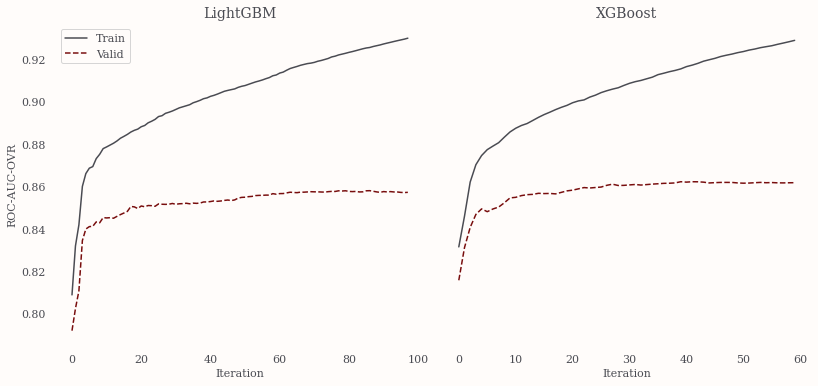

2024-03-14 22:16:21 - CV - INFO - Results
LightGBM - Best Iter: 134 - Valid ROC-AUC: 0.86174
XGBoost  - Best Iter: 126 - Valid ROC-AUC: 0.86869


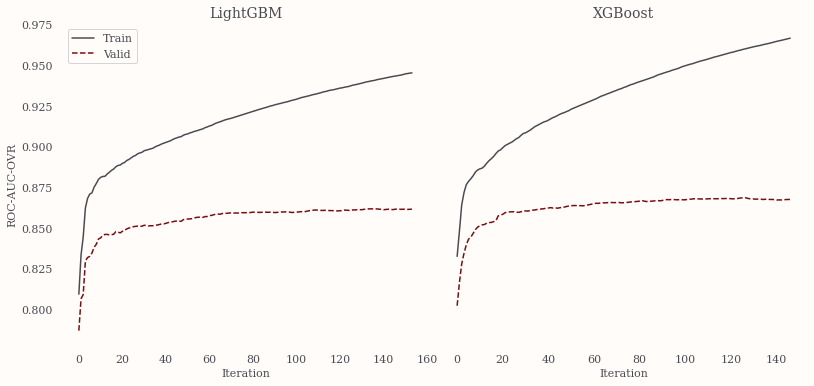

2024-03-14 22:16:38 - CV - INFO - Results
LightGBM - Best Iter: 93 - Valid ROC-AUC: 0.85718
XGBoost  - Best Iter: 49 - Valid ROC-AUC: 0.86815


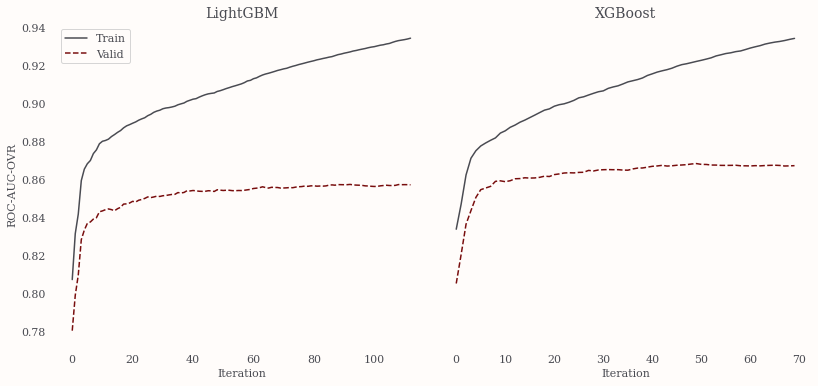

2024-03-14 22:16:55 - CV - INFO - Results
LightGBM - Best Iter: 89 - Valid ROC-AUC: 0.85272
XGBoost  - Best Iter: 60 - Valid ROC-AUC: 0.86577


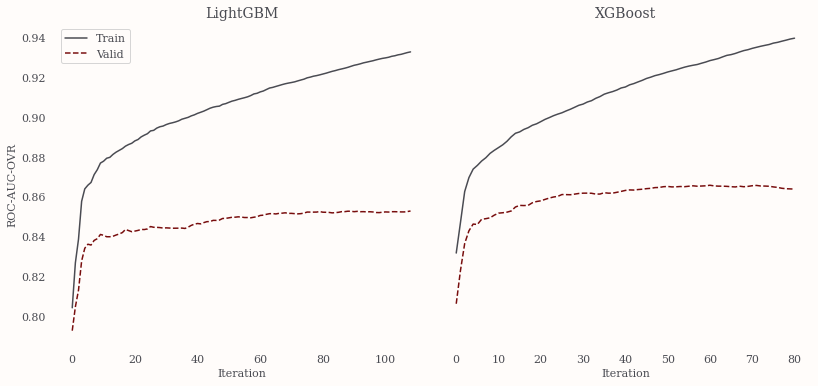

2024-03-14 22:17:12 - CV - INFO - Results
LightGBM - Best Iter: 81 - Valid ROC-AUC: 0.85236
XGBoost  - Best Iter: 64 - Valid ROC-AUC: 0.86417


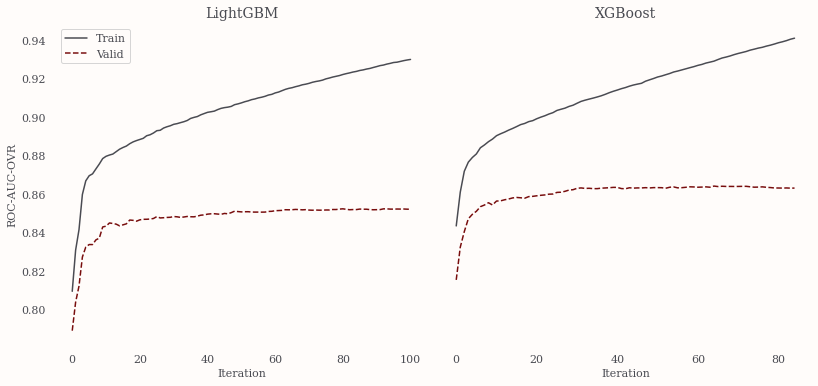

2024-03-14 22:17:13 - CV - INFO - Final Out-of-Fold ROC-AUC: 0.86387


In [39]:
encoder = LabelEncoder()
X = train_extended.drop(columns="Category")
y = np.asarray(encoder.fit_transform(train_extended.Category))

seed = 42
logger = logging.getLogger("CV")
y_proba = np.zeros((len(y), len(np.unique(y))), dtype=np.float32)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for train_ids, test_ids in skfold.split(X, y):
    X_train, y_train = X.iloc[train_ids], y[train_ids]
    X_test, y_test = X.iloc[test_ids], y[test_ids]
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.15, stratify=y_train, random_state=seed
    )

    X_train = preprocess.fit_transform(X_train)
    X_valid = preprocess.transform(X_valid)
    X_test = preprocess.transform(X_test)

    lgb_model, lgb_history, xgb_model, xgb_history = train_lgb_xgb(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid,
        lgb_params=lgb_params,
        xgb_params=xgb_params,
        lgb_feval=lgb_roc_auc_ovr,
        xgb_feval=xgb_roc_auc_ovr,
        num_iterations=NUM_ITERATIONS,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        min_delta=MIN_DELTA,
    )

    lgb_valid_auc = lgb_model.best_score["valid"]["roc_auc_ovr"]
    xgb_valid_auc = xgb_model.best_score
    logger.info(
        f"Results\n"
        f"LightGBM - Best Iter: {lgb_model.best_iteration} - Valid ROC-AUC: {lgb_valid_auc:.5f}\n"
        f"XGBoost  - Best Iter: {xgb_model.best_iteration} - Valid ROC-AUC: {xgb_valid_auc:.5f}"
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.5, 5.5), tight_layout=True, sharey=True)
    draw_valid_curves(
        lgb_history, ax=ax1, title="LightGBM", xlabel="Iteration", ylabel="ROC-AUC-OVR"
    )
    draw_valid_curves(
        xgb_history, ax=ax2, title="XGBoost", xlabel="Iteration", ylabel="", show_legend=False
    )
    plt.show()

    y_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
    y_xgb = xgb_model.predict(xgb.DMatrix(X_test), iteration_range=(0, xgb_model.best_iteration))
    y_proba[test_ids] = (y_lgb + y_xgb) / 2

oof_roc_auc = roc_auc_score(y, y_proba, average="macro", multi_class="ovr")
logger.info(f"Final Out-of-Fold ROC-AUC: {oof_roc_auc:.5f}")